In [1]:
import numpy as np
import pandas

from consts import DATA_PATH, HUMAN_DB, EXPERIMENT_RESULTS
from asodesigner.util import get_antisense
from util import get_antisense, get_gc_content

SEQUENCE = 'Sequence'
INHIBITION = 'Inhibition(%)'

In [2]:
all_data = pandas.read_csv(DATA_PATH / 'data_from_article_fixed.csv')
# all_data = all_data[all_data['Cell line organism'] == 'human']

In [3]:
all_data['gc_content'] = [get_gc_content(seq) for seq in all_data[SEQUENCE]]

In [4]:
from scipy.stats import pearsonr, spearmanr

def print_correlations(df, name1, name2, p_value_threshold=None):
    if p_value_threshold is None:
        p_value_threshold = 1
    corr, p_value = pearsonr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Pearson: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")
    corr, p_value = spearmanr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Spearman: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")


In [5]:
all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()

In [6]:
all_data_no_nan.loc[:, 'log_inhibition'] = -np.log(-all_data_no_nan[INHIBITION] + 100.001)

In [7]:
import ViennaRNA as RNA
all_data_no_nan.loc[:, 'internal_fold'] = [RNA.fold(antisense)[1] for antisense in all_data_no_nan[SEQUENCE]]

print_correlations(all_data_no_nan, 'internal_fold', INHIBITION)
print_correlations(all_data_no_nan, 'internal_fold', 'log_inhibition')

Feature: internal_fold                      , Pearson: 0.01 , p-value: 0.038      Target: Inhibition(%)                      
Feature: internal_fold                      , Spearman: 0.00 , p-value: 0.7        Target: Inhibition(%)                      
Feature: internal_fold                      , Pearson: 0.03 , p-value: 1.7e-06    Target: log_inhibition                     
Feature: internal_fold                      , Spearman: 0.00 , p-value: 0.7        Target: log_inhibition                     


In [8]:
from read_human_genome import get_locus_to_data_dict
gene_to_data = get_locus_to_data_dict(include_introns=True)

Time took to read fasta: 9.120603799819946


In [9]:
from consts import HUMAN_DB_BASIC_INTRONS
import gffutils

db = gffutils.FeatureDB(str(HUMAN_DB_BASIC_INTRONS))
gene = db.features_of_type('gene')

In [10]:
CANONICAL_GENE = 'Canonical Gene Name'
CELL_LINE_ORGANISM = 'Cell line organism'

all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']
genes = all_data_no_nan[CANONICAL_GENE].copy()
genes_u = list(set(genes))
genes_u.remove('HBV')
genes_u.remove('negative_control')

In [11]:
for gene_name in genes_u:
    if gene_name not in gene_to_data:
        print(f"gene : {gene_name} not found")

In [12]:
all_data_human_gene = all_data_no_nan_human[all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)].copy()
PREMRNA_FOUND = 'pre_mrna_found'
SENSE_START = 'sense_start'
SENSE_LENGTH = 'sense_length'
SENSE_TYPE = 'sense_type'
found = 0
not_found = 0
all_data_human_gene[SENSE_START] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)
all_data_human_gene[SENSE_LENGTH] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)
all_data_human_gene[SENSE_TYPE] = ''
for index, row in all_data_human_gene.iterrows():
     gene_name = row[CANONICAL_GENE]
     pre_mrna = gene_to_data[gene_name].full_mrna
     antisense = row[SEQUENCE]
     sense = get_antisense(antisense)
     idx = pre_mrna.find(sense)
     all_data_human_gene.loc[index, SENSE_START] = idx
     all_data_human_gene.loc[index, SENSE_LENGTH] = len(antisense)


In [13]:
all_data_human_gene_premrna = all_data_human_gene[all_data_human_gene[SENSE_START] != -1]
len(all_data_human_gene_premrna)


29987

In [14]:
from fold import get_trigger_mfe_scores_by_risearch, get_mfe_scores, dump_target_file
import random

# minimal_scores = [200,400,600,800,1000,1200]
minimal_scores = [800]
on_target_feature_titles = ['on_target_energy_fits', 'on_target_energy_sum', 'on_target_energy_max']

all_data_human_gene_premrna = all_data_human_gene_premrna.copy() # so Jupyter doesn't shout at me

# genes_u.remove('HIF1A') # the same sequence for all ASOs, only differing chemical modifications
for score in minimal_scores:
    for feature_title in on_target_feature_titles:
        all_data_human_gene_premrna.loc[:, feature_title + str(score)] = np.zeros_like(all_data_human_gene_premrna[SEQUENCE], dtype=np.float64)

    for gene in genes_u:
        target = gene_to_data[gene].full_mrna
        name_to_sequence = {'target_seq' : target}
        results = []
        parsing_type = '2'

        hash = random.getrandbits(64)
        target_cache_filename = f'target-cache-{hash}.fa'
        target_cache_path = dump_target_file(target_cache_filename, name_to_sequence)

        gene_rows = all_data_human_gene_premrna[all_data_human_gene_premrna[CANONICAL_GENE] == gene]

        for index, row in gene_rows.iterrows():
            antisense = row[SEQUENCE]
            sense = get_antisense(antisense)
            l = row[SENSE_LENGTH]
            tmp_results = get_trigger_mfe_scores_by_risearch(sense, name_to_sequence, minimum_score=score, neighborhood=l,
                                                     parsing_type=parsing_type, target_file_cache=target_cache_path)
            scores = get_mfe_scores(tmp_results, parsing_type)
            if len(scores) == 0:
                all_data_human_gene_premrna.loc[index, 'on_target_energy_fits' + str(score)] = 0.
                all_data_human_gene_premrna.loc[index, 'on_target_energy_sum' + str(score)] = 0.
                all_data_human_gene_premrna.loc[index, 'on_target_energy_max' + str(score)] = 0.
            else:
                target_scores = scores[0]
                min_score = 0 if len(target_scores) == 0 else min(target_scores)
                all_data_human_gene_premrna.loc[index, 'on_target_energy_fits' + str(score)] = len(target_scores)
                all_data_human_gene_premrna.loc[index, 'on_target_energy_sum' + str(score)] = sum(target_scores)
                all_data_human_gene_premrna.loc[index, 'on_target_energy_max' + str(score)] = min_score



In [15]:
on_target_energy_features = ['on_target_energy_fits' + str(score) for score in minimal_scores] + ['on_target_energy_sum' + str(score) for score in minimal_scores] + ['on_target_energy_max' + str(score) for score in minimal_scores]
on_target_energy_features

['on_target_energy_fits800',
 'on_target_energy_sum800',
 'on_target_energy_max800']

In [16]:
for score in minimal_scores:
    for on_target_name in on_target_feature_titles:
        all_data_human_gene_premrna.loc[:, on_target_name + "_normalized" + str(score)] = all_data_human_gene_premrna['on_target_energy_fits' + str(score)] / all_data_human_gene_premrna[SENSE_LENGTH]
        on_target_energy_features.append(on_target_name + "_normalized" + str(score))

        ISIS Target_gene Cell_line  Density(cells/well)     Transfection  \
996   709836        SNCA   SH-SY5Y              20000.0  electroporation   
1424  740331        SNCA   SH-SY5Y              20000.0  electroporation   
1220  709839        SNCA   SH-SY5Y              20000.0  electroporation   
1425  740332        SNCA   SH-SY5Y              20000.0  electroporation   
1426  740333        SNCA   SH-SY5Y              20000.0  electroporation   

      ASO_volume(nM)  Treatment_Period(hours) Primer_probe_set  \
996           7000.0                       24          RTS2621   
1424          7000.0                       24          RTS2621   
1220          7000.0                       24          RTS2621   
1425          7000.0                       24          RTS2621   
1426          7000.0                       24          RTS2621   

               Sequence                     Modification  ... internal_fold  \
996   GGCGACGCGAGGCTGGG  MOE/cEt/5-methylcytosines/deoxy  ...      

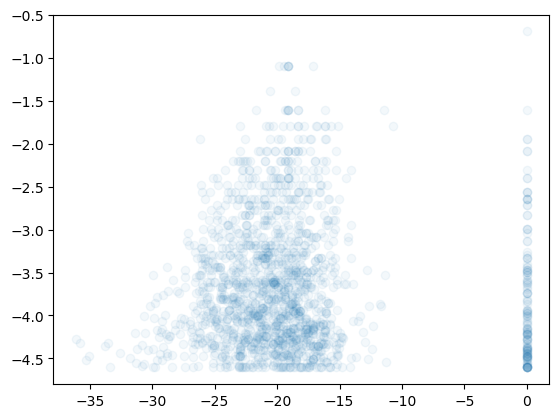

In [17]:
test = all_data_human_gene_premrna[all_data_human_gene_premrna[CANONICAL_GENE] == 'SNCA']
test = test.sort_values(by=['on_target_energy_max800'], ascending=[False])
print(test.tail(5))
import matplotlib.pyplot as plt
plt.scatter(test['on_target_energy_max800'], test['log_inhibition'], alpha=0.05)
plt.show()

In [35]:
from fold import calculate_energies, get_weighted_energy

all_data_human_gene_premrna_no_nan = all_data_human_gene_premrna.copy()

# fold_variants = [(40, 15), (50, 15), (60, 15), (40, 20), (50, 20), (40, 30), (60, 30)]
# fold_variants = [(40, 15), (60, 15), (80, 15), (100, 15), (60, 25), (80, 25), (100, 25), (80, 40), (100, 40)]
fold_variants = [(40, 15)]
for (window_size, step_size) in fold_variants:
    on_target_fold = 'on_target_fold_openness' + str(window_size) + '_' + str(step_size)
    on_target_fold_normalized = 'on_target_fold_openness_normalized' + str(window_size) + '_' + str(step_size)

    all_data_human_gene_premrna_no_nan[on_target_fold] = np.zeros_like(all_data_human_gene_premrna_no_nan[SEQUENCE], dtype=np.float64)
    all_data_human_gene_premrna_no_nan[on_target_fold_normalized] = np.zeros_like(all_data_human_gene_premrna_no_nan[SEQUENCE], dtype=np.float64)
    for gene in genes_u:

        # on_target_fold = 'on_target_fold_openness'
        # on_target_fold_normalized = 'on_target_fold_openness_normalized'

        target = gene_to_data[gene].full_mrna
        gene_rows = all_data_human_gene_premrna_no_nan[all_data_human_gene_premrna_no_nan[CANONICAL_GENE] == gene]
        energies = calculate_energies(str(target), step_size, window_size)

        for index, row in gene_rows.iterrows():
            antisense = row[SEQUENCE]
            sense = get_antisense(antisense)
            l = row[SENSE_LENGTH]
            sense_start = row[SENSE_START]
            mean_fold = get_weighted_energy(sense_start, l, step_size, energies, window_size)

            all_data_human_gene_premrna_no_nan.loc[index, on_target_fold] = mean_fold
            all_data_human_gene_premrna_no_nan.loc[index, on_target_fold_normalized] = mean_fold / float(l)


In [36]:
fold_feature_names = ['on_target_fold_openness', 'on_target_fold_openness_normalized']
fold_features = []
for (window_size, step_size) in fold_variants:
    for feature_name in fold_feature_names:
        fold_features.append(feature_name + str(window_size) + "_" + str(step_size))

In [37]:
print(all_data_human_gene_premrna_no_nan.columns)

Index(['ISIS', 'Target_gene', 'Cell_line', 'Density(cells/well)',
       'Transfection', 'ASO_volume(nM)', 'Treatment_Period(hours)',
       'Primer_probe_set', 'Sequence', 'Modification', 'Location',
       'Chemical_Pattern', 'Linkage', 'Linkage_Location', 'Smiles',
       'Inhibition(%)', 'seq_length', 'Canonical Gene Name',
       'Cell line organism', 'gc_content', 'log_inhibition', 'internal_fold',
       'sense_start', 'sense_length', 'sense_type', 'on_target_energy_fits800',
       'on_target_energy_sum800', 'on_target_energy_max800',
       'on_target_energy_fits_normalized800',
       'on_target_energy_sum_normalized800',
       'on_target_energy_max_normalized800', 'on_target_fold_openness40_15',
       'on_target_fold_openness_normalized40_15'],
      dtype='object')


In [38]:
all_data_human_gene_premrna_no_nan[all_data_human_gene_premrna_no_nan['on_target_fold_openness40_15'] < -.01]

,ISIS,Target_gene,Cell_line,Density(cells/well),Transfection,ASO_volume(nM),Treatment_Period(hours),Primer_probe_set,Sequence,Modification,...,sense_length,sense_type,on_target_energy_fits800,on_target_energy_sum800,on_target_energy_max800,on_target_energy_fits_normalized800,on_target_energy_sum_normalized800,on_target_energy_max_normalized800,on_target_fold_openness40_15,on_target_fold_openness_normalized40_15
0,540733,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCTAAAACAAATGCTA,cEt/5-methylcytosines/deoxy,...,16,,1.0,-18.05,-18.05,0.0625,0.0625,0.0625,-3.095833,-0.193490
1,540747,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,TATAATGGTGAATATC,cEt/5-methylcytosines/deoxy,...,16,,1.0,-16.55,-16.55,0.0625,0.0625,0.0625,-5.918750,-0.369922
2,540806,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GCATGAAGATTTCTGG,cEt/5-methylcytosines/deoxy,...,16,,1.0,-19.70,-19.70,0.0625,0.0625,0.0625,-3.056250,-0.191016
3,651479,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,GGTGAATATCTTCAAA,cEt/5-methylcytosines/deoxy,...,16,,1.0,-17.05,-17.05,0.0625,0.0625,0.0625,-4.948958,-0.309310
4,651490,K-RAS,A431,5000.0,free uptake,2000.0,24,RTS3496_MGB,CACTTGTACTAGTATG,cEt/5-methylcytosines/deoxy,...,16,,1.0,-17.00,-17.00,0.0625,0.0625,0.0625,-6.430208,-0.401888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36885,905505,APOL1,A431,10000.0,free uptake,40.0,16,RTS35962,GTTATGAAATTATTGG,cEt/5-methylcytosines/deoxy,...,16,,0.0,0.00,0.00,0.0000,0.0000,0.0000,-2.217708,-0.138607
36886,905634,APOL1,A431,10000.0,free uptake,40.0,16,RTS35962,ATTCTATTAGAGGGCT,cEt/5-methylcytosines/deoxy,...,16,,89.0,-852.35,-18.50,5.5625,5.5625,5.5625,-5.233334,-0.327083
36887,905665,APOL1,A431,10000.0,free uptake,40.0,16,RTS35962,GCTTTAAACTCAGGTG,cEt/5-methylcytosines/deoxy,...,16,,5.0,-59.65,-19.40,0.3125,0.3125,0.3125,-2.772917,-0.173307
36888,972163,APOL1,A431,10000.0,free uptake,40.0,16,RTS35962,CGTCAATATATTCTTT,MOE/cEt/5-methylcytosines/deoxy,...,16,,0.0,0.00,0.00,0.0000,0.0000,0.0000,-0.533333,-0.033333


Feature: on_target_fold_openness40_15       , Pearson: -0.02, p-value: 0.00012    Target: Inhibition(%)                      
Feature: on_target_fold_openness40_15       , Spearman: 0.13 , p-value: 3.8e-119   Target: Inhibition(%)                      
Feature: on_target_fold_openness40_15       , Pearson: -0.02, p-value: 0.0016     Target: log_inhibition                     
Feature: on_target_fold_openness40_15       , Spearman: 0.13 , p-value: 3.8e-119   Target: log_inhibition                     
Feature: on_target_fold_openness_normalized40_15, Pearson: -0.02, p-value: 0.00019    Target: Inhibition(%)                      
Feature: on_target_fold_openness_normalized40_15, Spearman: 0.17 , p-value: 3.6e-190   Target: Inhibition(%)                      
Feature: on_target_fold_openness_normalized40_15, Pearson: -0.02, p-value: 0.0019     Target: log_inhibition                     
Feature: on_target_fold_openness_normalized40_15, Spearman: 0.17 , p-value: 3.6e-190   Target: log_inhi

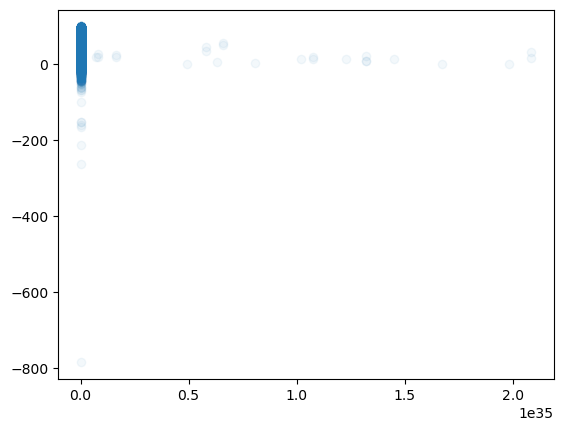

In [40]:
test = all_data_human_gene_premrna_no_nan
# test = all_data_human_gene_premrna_no_nan[all_data_human_gene_premrna_no_nan[INHIBITION] > 0]


for feature_name in fold_features:
    print_correlations(test , feature_name, INHIBITION, p_value_threshold=0.05)
    print_correlations(test , feature_name, 'log_inhibition', p_value_threshold=0.05)

feature = fold_features[0]
plt.scatter(test[feature], test[INHIBITION], alpha=0.05)
plt.show()


In [44]:
print(all_data_human_gene_premrna_no_nan[(all_data_human_gene_premrna_no_nan[feature] > 1.)])

         ISIS Target_gene Cell_line  Density(cells/well)     Transfection  \
30016  596354       SOD-1     HepG2              20000.0  electroporation   
30017  596355       SOD-1     HepG2              20000.0  electroporation   
30018  596356       SOD-1     HepG2              20000.0  electroporation   
30019  596357       SOD-1     HepG2              20000.0  electroporation   
30020  596358       SOD-1     HepG2              20000.0  electroporation   
30021  596359       SOD-1     HepG2              20000.0  electroporation   
30022  596360       SOD-1     HepG2              20000.0  electroporation   
30023  596361       SOD-1     HepG2              20000.0  electroporation   
30024  596362       SOD-1     HepG2              20000.0  electroporation   
30249  596713       SOD-1     HepG2              20000.0  electroporation   
30250  596904       SOD-1     HepG2              20000.0  electroporation   
30251  596714       SOD-1     HepG2              20000.0  electroporation   

In [45]:
all_data_human_gene_premrna_no_nan.loc[:, 'energy_and_fold'] = all_data_human_gene_premrna_no_nan['on_target_energy_max800'] * all_data_human_gene_premrna_no_nan['on_target_fold_openness_normalized40_15']

print_correlations(all_data_human_gene_premrna_no_nan, 'energy_and_fold', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'energy_and_fold', 'log_inhibition')

Feature: energy_and_fold                    , Pearson: 0.02 , p-value: 0.0011     Target: Inhibition(%)                      
Feature: energy_and_fold                    , Spearman: -0.13, p-value: 1.6e-120   Target: Inhibition(%)                      
Feature: energy_and_fold                    , Pearson: 0.02 , p-value: 0.0068     Target: log_inhibition                     
Feature: energy_and_fold                    , Spearman: -0.13, p-value: 1.6e-120   Target: log_inhibition                     


In [46]:
import primer3

all_data_human_gene_premrna_no_nan.loc[:, 'self_energy'] = [float(primer3.calc_homodimer(antisense).dg) for antisense in all_data_human_gene_premrna_no_nan[SEQUENCE]]
all_data_human_gene_premrna_no_nan.loc[:, 'self_energy'] = all_data_human_gene_premrna_no_nan.loc[:, 'self_energy'].astype(float)

print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy', 'log_inhibition')

Feature: self_energy                        , Pearson: 0.02 , p-value: 0.0013     Target: Inhibition(%)                      
Feature: self_energy                        , Spearman: 0.01 , p-value: 0.095      Target: Inhibition(%)                      
Feature: self_energy                        , Pearson: 0.02 , p-value: 0.0049     Target: log_inhibition                     
Feature: self_energy                        , Spearman: 0.01 , p-value: 0.095      Target: log_inhibition                     


In [47]:
all_data_human_gene_premrna_no_nan.loc[:, 'internal_fold'] = [RNA.fold(antisense)[1] for antisense in all_data_human_gene_premrna_no_nan[SEQUENCE]]

print_correlations(all_data_human_gene_premrna_no_nan, 'internal_fold', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'internal_fold', 'log_inhibition')

Feature: internal_fold                      , Pearson: 0.00 , p-value: 0.66       Target: Inhibition(%)                      
Feature: internal_fold                      , Spearman: 0.00 , p-value: 0.6        Target: Inhibition(%)                      
Feature: internal_fold                      , Pearson: -0.02, p-value: 0.0057     Target: log_inhibition                     
Feature: internal_fold                      , Spearman: 0.00 , p-value: 0.6        Target: log_inhibition                     


In [48]:
all_data_human_gene_premrna_no_nan.loc[:, 'gc_content_5_prime_5'] = [get_gc_content(sequence[:5]) for sequence in all_data_human_gene_premrna_no_nan[SEQUENCE]]
all_data_human_gene_premrna_no_nan.loc[:, 'gc_content_3_prime_5'] = [get_gc_content(sequence[-5:]) for sequence in all_data_human_gene_premrna_no_nan[SEQUENCE]]
all_data_human_gene_premrna_no_nan.loc[:, 'first_nucleotide'] = [sequence[0] for sequence in all_data_human_gene_premrna_no_nan[SEQUENCE]]
all_data_human_gene_premrna_no_nan.loc[:, 'second_nucleotide'] = [sequence[2] for sequence in all_data_human_gene_premrna_no_nan[SEQUENCE]]

print_correlations(all_data_human_gene_premrna_no_nan, 'gc_content_5_prime_5', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'gc_content_5_prime_5', 'log_inhibition')
print_correlations(all_data_human_gene_premrna_no_nan, 'gc_content_3_prime_5', 'log_inhibition')
print_correlations(all_data_human_gene_premrna_no_nan, 'gc_content_3_prime_5', 'log_inhibition')

Feature: gc_content_5_prime_5               , Pearson: -0.03, p-value: 1.4e-06    Target: Inhibition(%)                      
Feature: gc_content_5_prime_5               , Spearman: -0.02, p-value: 0.00013    Target: Inhibition(%)                      
Feature: gc_content_5_prime_5               , Pearson: -0.02, p-value: 2.2e-05    Target: log_inhibition                     
Feature: gc_content_5_prime_5               , Spearman: -0.02, p-value: 0.00013    Target: log_inhibition                     
Feature: gc_content_3_prime_5               , Pearson: 0.05 , p-value: 1e-17      Target: log_inhibition                     
Feature: gc_content_3_prime_5               , Spearman: 0.04 , p-value: 6.6e-12    Target: log_inhibition                     
Feature: gc_content_3_prime_5               , Pearson: 0.05 , p-value: 1e-17      Target: log_inhibition                     
Feature: gc_content_3_prime_5               , Spearman: 0.04 , p-value: 6.6e-12    Target: log_inhibition          

In [49]:
import primer3

all_data_human_gene_premrna_no_nan.loc[:, 'self_energy'] = [primer3.calc_homodimer(antisense).dg for antisense in all_data_human_gene_premrna_no_nan[SEQUENCE]]
all_data_human_gene_premrna_no_nan.loc[:, 'self_energy_log'] = -np.log(2500-all_data_human_gene_premrna_no_nan.loc[:, 'self_energy'])

print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy', 'log_inhibition')
print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy_log', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy_log', 'log_inhibition')

Feature: self_energy                        , Pearson: 0.02 , p-value: 0.0013     Target: Inhibition(%)                      
Feature: self_energy                        , Spearman: 0.01 , p-value: 0.095      Target: Inhibition(%)                      
Feature: self_energy                        , Pearson: 0.02 , p-value: 0.0049     Target: log_inhibition                     
Feature: self_energy                        , Spearman: 0.01 , p-value: 0.095      Target: log_inhibition                     
Feature: self_energy_log                    , Pearson: 0.01 , p-value: 0.32       Target: Inhibition(%)                      
Feature: self_energy_log                    , Spearman: 0.01 , p-value: 0.095      Target: Inhibition(%)                      
Feature: self_energy_log                    , Pearson: 0.01 , p-value: 0.19       Target: log_inhibition                     
Feature: self_energy_log                    , Spearman: 0.01 , p-value: 0.095      Target: log_inhibition          

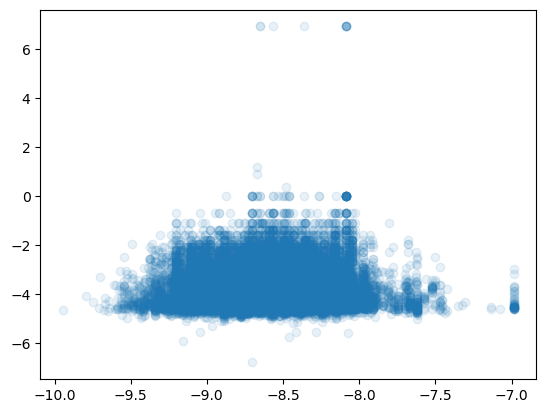

In [50]:
import matplotlib.pyplot as plt
plt.scatter(all_data_human_gene_premrna_no_nan['self_energy_log'], all_data_human_gene_premrna_no_nan['log_inhibition'], alpha=0.1)
plt.show()

Feature: Treatment_Period(hours)            , Pearson: -0.15, p-value: 3.2e-143   Target: Inhibition(%)                      
Feature: Treatment_Period(hours)            , Spearman: -0.27, p-value: 0.0        Target: Inhibition(%)                      
Feature: Treatment_Period(hours)            , Pearson: -0.14, p-value: 4.3e-125   Target: log_inhibition                     
Feature: Treatment_Period(hours)            , Spearman: -0.27, p-value: 0.0        Target: log_inhibition                     


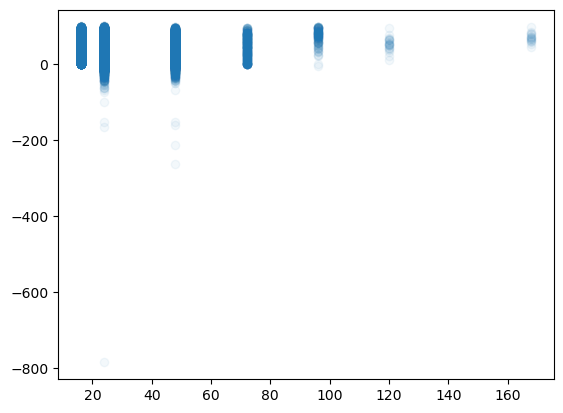

In [51]:
VOLUME = 'ASO_volume(nM)'
TREATMENT_PERIOD = 'Treatment_Period(hours)'
CELL_LINE = 'Cell_line'
TRANSFECTION = 'Transfection'
DENSITY = 'Density(cells/well)'

print_correlations(all_data_human_gene_premrna_no_nan, TREATMENT_PERIOD, INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, TREATMENT_PERIOD, 'log_inhibition')
plt.scatter(all_data_human_gene_premrna_no_nan[TREATMENT_PERIOD], all_data_human_gene_premrna_no_nan[INHIBITION], alpha=0.05)
plt.show()

Feature: Density(cells/well)                , Pearson: 0.17 , p-value: 1.5e-168   Target: Inhibition(%)                      
Feature: Density(cells/well)                , Spearman: 0.18 , p-value: 1e-195     Target: Inhibition(%)                      
Feature: Density(cells/well)                , Pearson: 0.09 , p-value: 6.5e-47    Target: log_inhibition                     
Feature: Density(cells/well)                , Spearman: 0.18 , p-value: 1e-195     Target: log_inhibition                     
Feature: log_density                        , Pearson: 0.17 , p-value: 8.6e-172   Target: Inhibition(%)                      
Feature: log_density                        , Spearman: 0.18 , p-value: 1e-195     Target: Inhibition(%)                      
Feature: log_density                        , Pearson: 0.10 , p-value: 8.2e-55    Target: log_inhibition                     
Feature: log_density                        , Spearman: 0.18 , p-value: 1e-195     Target: log_inhibition          

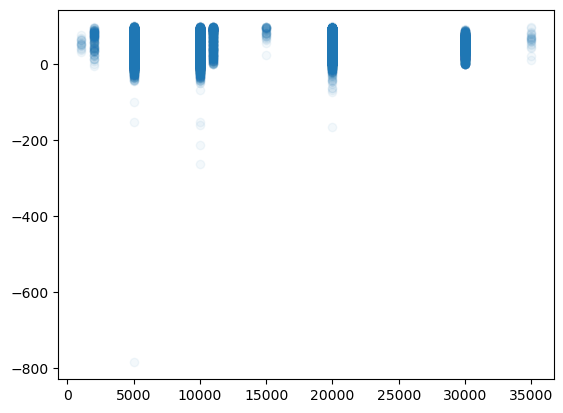

In [52]:
tmp = all_data_human_gene_premrna_no_nan.copy()
tmp = tmp.dropna(subset=[DENSITY]).copy()
tmp.loc[:, 'log_density'] = np.log(tmp[DENSITY])

print_correlations(tmp, DENSITY, INHIBITION)
print_correlations(tmp, DENSITY, 'log_inhibition')
print_correlations(tmp, 'log_density', INHIBITION)
print_correlations(tmp, 'log_density', 'log_inhibition')
plt.scatter(tmp[DENSITY], tmp[INHIBITION], alpha=0.05)
plt.show()

Feature: normalized_start                   , Pearson: 0.10 , p-value: 5.5e-66    Target: Inhibition(%)                      
Feature: normalized_start                   , Spearman: 0.10 , p-value: 1.5e-67    Target: Inhibition(%)                      
Feature: normalized_start                   , Pearson: 0.05 , p-value: 5.1e-19    Target: log_inhibition                     
Feature: normalized_start                   , Spearman: 0.10 , p-value: 1.5e-67    Target: log_inhibition                     


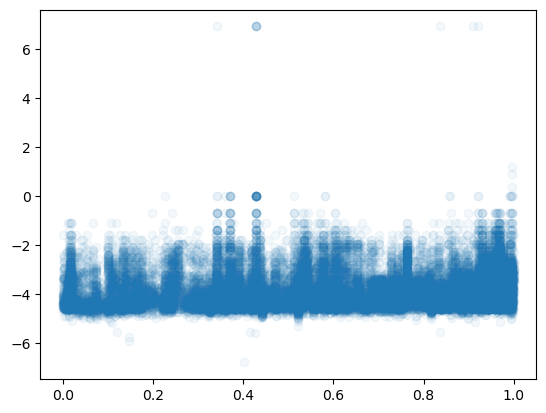

In [53]:
all_data_human_gene_premrna_no_nan.loc[:, 'mrna_length'] = [len(gene_to_data[gene].full_mrna) for gene in all_data_human_gene_premrna_no_nan[CANONICAL_GENE]]
all_data_human_gene_premrna_no_nan.loc[:, 'normalized_start'] = all_data_human_gene_premrna_no_nan[SENSE_START] / all_data_human_gene_premrna_no_nan['mrna_length']

print_correlations(all_data_human_gene_premrna_no_nan, 'normalized_start', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'normalized_start', 'log_inhibition')


plt.scatter(all_data_human_gene_premrna_no_nan['normalized_start'], all_data_human_gene_premrna_no_nan['log_inhibition'], alpha=0.05)
plt.show()

Feature: purine_content                     , Pearson: -0.05, p-value: 5.5e-15    Target: Inhibition(%)                      
Feature: purine_content                     , Spearman: -0.04, p-value: 1.2e-13    Target: Inhibition(%)                      


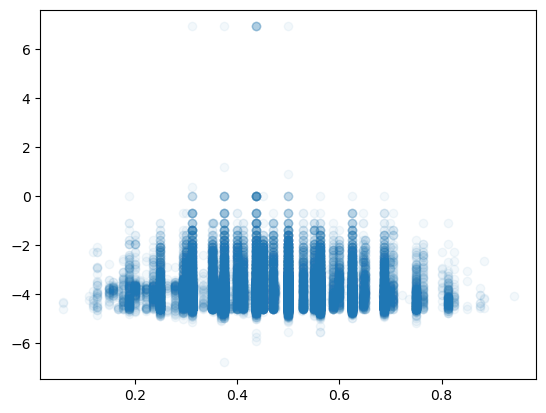

In [55]:
from util import get_purine_content

all_data_human_gene_premrna_no_nan.loc[:, 'purine_content'] = [get_purine_content(seq) for seq in all_data_human_gene_premrna_no_nan[SEQUENCE]]

print_correlations(all_data_human_gene_premrna_no_nan, 'purine_content', INHIBITION)
plt.scatter(all_data_human_gene_premrna_no_nan['purine_content'], all_data_human_gene_premrna_no_nan['log_inhibition'], alpha=0.05)
plt.show()


In [76]:
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection  import train_test_split, cross_val_score
from sklearn.metrics import make_scorer
import pandas as pd

filtered = all_data_human_gene_premrna_no_nan
filtered = filtered[filtered['Cell line organism'] == 'human']
print(len(filtered))
filtered = filtered.dropna(subset=[INHIBITION]).copy()
filtered = filtered.dropna(subset=[DENSITY]).copy()
filtered = pd.get_dummies(filtered, columns=[CELL_LINE]).copy()
filtered = pd.get_dummies(filtered, columns=[TRANSFECTION]).copy()
filtered = pd.get_dummies(filtered, columns=['first_nucleotide']).copy()
filtered = pd.get_dummies(filtered, columns=['second_nucleotide']).copy()
filtered = pd.get_dummies(filtered, columns=['Modification']).copy()


filtered['log_volume'] = np.log(filtered[VOLUME])
filtered.loc[:, 'log_inhibition'] = -np.log(-filtered[INHIBITION] + 101)
filtered.loc[:, 'log_density'] = np.log(filtered[DENSITY])
filtered.loc[:, SENSE_LENGTH] = [len(sequence) for sequence in filtered[SEQUENCE]]
filtered.loc[:, SENSE_LENGTH] = filtered.loc[:, SENSE_LENGTH].astype(float)
filtered['gc_deviation'] = np.abs(0.5 - filtered['gc_content'])
filtered['self_energy_log_squared'] = filtered['self_energy_log'] ** 2
filtered['purine_content'] = [get_purine_content(seq) for seq in filtered[SEQUENCE]]
# filtered['self_energy_squared'] = filtered['self_energy'] ** 2

# features_base = ['log_volume', TREATMENT_PERIOD, VOLUME]
features_base = ['gc_content', 'gc_deviation', 'purine_content', SENSE_LENGTH, 'normalized_start', SENSE_START, 'self_energy_log', 'self_energy_log_squared', 'internal_fold', 'energy_and_fold', 'gc_content_3_prime_5', 'gc_content_5_prime_5']
experiment_features = [VOLUME, 'log_volume', TREATMENT_PERIOD, 'log_density']
cell_line_features = [feature for feature in filtered.columns if 'Cell_line' in feature and 'Cell_line' != feature]
transfection_features = [feature for feature in filtered.columns if TRANSFECTION in feature and TRANSFECTION != feature]
nucleotide_features = [feature for feature in filtered.columns if 'nucleotide' in feature and feature not in ['first_nucleotide', 'second_nucleotide']]
modification_features = [feature for feature in filtered.columns if 'Modification' in feature and feature != 'Modification']

features = features_base + experiment_features + cell_line_features + transfection_features + on_target_energy_features + fold_features + nucleotide_features + modification_features

print("Used features: ", features)

# filtered = all_data_human_gene_premrna_no_nan
common_chemical_pattern = 'CCCddddddddddCCC'

# filtered = filtered[filtered['Chemical_Pattern'] == common_chemical_pattern]
# filtered = filtered[filtered[CANONICAL_GENE] == 'IRF5']
# filtered = filtered[filtered[CANONICAL_GENE] == 'KRAS']
# filtered = filtered[filtered[INHIBITION] > 0]
# filtered = filtered[filtered[VOLUME] == 4000]
# filtered = filtered[filtered[INHIBITION] > 70]

# train, test = train_test_split(filtered, test_size=0.2, random_state=0, stratify=filtered[CANONICAL_GENE])
train, test = train_test_split(filtered, test_size=0.2)

print("Test: ", len(test))
print("Train: ", len(train))
X = train[features]
y = train['log_inhibition']
# x_tag = X
# y_tag = y

weight = VOLUME


# Multiply the values via numpy without changing the column names
multiplier = np.sqrt(X[weight]).values.reshape(-1, 1)
X_tag = pd.DataFrame(
    X[features].values * multiplier,
    index=X.index,
    columns=X[features].columns)


y_tag  = y * np.sqrt(X[weight])

# model = LinearRegression()
# model.fit(X_tag, y_tag)
# model = LinearRegression(n_jobs=-1)

model = RandomForestRegressor(random_state=42, n_jobs=1)

# model.fit(X,y)
model.fit(train[features], train['log_inhibition'])


baseline_score = cross_val_score(model, X, y, cv=5,  n_jobs=1).mean()
print("Baseline score: ", baseline_score)

def spearman_score(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred).correlation ** 2

spearman_scorer = make_scorer(spearman_score, greater_is_better=True)
spearman_score = cross_val_score(model, X, y, cv=5, scoring=spearman_scorer, n_jobs=1).mean()
print("Spearman score: ", spearman_score)

# test = test[test[CANONICAL_GENE] == 'MAPT']
# test = test[test['Chemical_Pattern'] == 'CCCddddddddddCCC']
# test = test[test[INHIBITION] > 90]

test_features = test[features]
#
# multiplier = np.sqrt(test[weight]).values.reshape(-1, 1)
# test_features = pd.DataFrame(
#     test[features].values * multiplier,
#     index=test.index,
#     columns=test[features].columns)
predicted = model.predict(test[features])


# test_features = test[features]
# predicted = model.predict(test_features)
# y_test = test['log_inhibition'] / np.sqrt(test[weight])
y_test = test['log_inhibition']


corr, p_value = pearsonr(y_test, predicted)
print("Pearson Corr: ", corr, " p_value: ", p_value)
corr, p_value = spearmanr(y_test, predicted)
print("Spearman Corr: ", corr, " p_value: ", p_value)



29987
Used features:  ['gc_content', 'gc_deviation', 'purine_content', 'sense_length', 'normalized_start', 'sense_start', 'self_energy_log', 'self_energy_log_squared', 'internal_fold', 'energy_and_fold', 'gc_content_3_prime_5', 'gc_content_5_prime_5', 'ASO_volume(nM)', 'log_volume', 'Treatment_Period(hours)', 'log_density', 'Cell_line_A-431', 'Cell_line_A431', 'Cell_line_H929', 'Cell_line_HepG2', 'Cell_line_HepaRG', 'Cell_line_Human IPS', 'Cell_line_KARPAS-229', 'Cell_line_KMS11', 'Cell_line_MM.1R', 'Cell_line_NCI-H460', 'Cell_line_SH-SY5Y', 'Cell_line_SK-MEL-28', 'Cell_line_SNU-449', 'Cell_line_U251', 'Transfection_Lipofectin reagent', 'Transfection_electroporation', 'Transfection_free uptake', 'Transfection_uptake', 'on_target_energy_fits800', 'on_target_energy_sum800', 'on_target_energy_max800', 'on_target_energy_fits_normalized800', 'on_target_energy_sum_normalized800', 'on_target_energy_max_normalized800', 'on_target_fold_openness40_15', 'on_target_fold_openness_normalized40_15', 

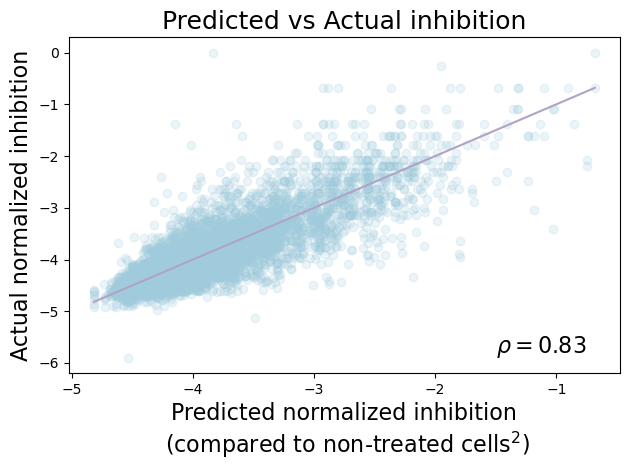

In [105]:
plt.scatter(predicted, y_test, alpha=0.2, color='#9FCBDC')
# plt.scatter(y_test, test['gc_content'])
x = np.linspace(np.min(predicted), np.max(predicted), 100)
plt.plot(x, x, color='#B0A3C4')

plt.xlabel('Predicted normalized inhibition\n (compared to non-treated cells$^{2}$)', fontsize=16)
plt.ylabel('Actual normalized inhibition', fontsize=16)
plt.title('Predicted vs Actual inhibition', fontsize=18)
plt.text(-1.5, -5.8, r'$\rho = %.2f$' % 0.83, fontsize=16)
plt.tight_layout()

plt.savefig('predicted_vs_actual_inhibition3.png', transparent=True)
plt.show()

In [103]:
test2 = test[test[INHIBITION] > 90]
predicted2 = model.predict(test2[features])
y_test2 = test2['log_inhibition']
corr, p_value = pearsonr(y_test2, predicted2)
print(corr)

0.35565976837516333


In [ ]:
from sklearn.model_selection import permutation_test_score

score, permutation_scores, pvalue = permutation_test_score(model, X, y, cv=5, n_permutations=100, n_jobs=-1, scoring='r2')
print(score, permutation_scores, pvalue)

In [ ]:
plt.scatter(filtered['self_energy_log_squared'], filtered['log_inhibition'], alpha=0.1)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import rankdata

def partial_corr(x, y, z):
    # Regress x on z
    X = sm.add_constant(z)
    model_x = sm.OLS(x, X).fit()
    res_x = model_x.resid

    # Regress y on z
    model_y = sm.OLS(y, X).fit()
    res_y = model_y.resid

    # Compute correlation between the residuals
    return np.corrcoef(res_x, res_y)[0, 1]

def partial_spearman_corr(x, y, z):
    # Convert variables to ranks
    rx = rankdata(x)
    ry = rankdata(y)
    rz = rankdata(z)

    # Regress rx on rz
    X = sm.add_constant(rz)
    model_x = sm.OLS(rx, X).fit()
    res_x = model_x.resid

    # Regress ry on rz
    model_y = sm.OLS(ry, X).fit()
    res_y = model_y.resid

    # Compute the Pearson correlation between the residuals
    return np.corrcoef(res_x, res_y)[0, 1]


for gene in genes_u:
    t = filtered[filtered[CANONICAL_GENE] == gene]
    print("Gene:", gene)
    try:
        pcorr = partial_spearman_corr(t['self_energy'], t['log_inhibition'], t['gc_content'])
        print(pcorr)
    except:
        pass

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(filtered[features], filtered['log_inhibition'])

# Get the feature importances
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)



In [ ]:
for index, row in importance_df.iterrows():
    print(f"{row['Feature']:<40} {row['Importance']:.3}")


In [ ]:
print("The baseline is: ", baseline_score)
print("The spearman baseline is: ", spearman_score)
cv = 5
scorer = None
jobs = -1
feature_importances = []

for feature in features_base + on_target_energy_features + fold_features:
    score_without_feature = cross_val_score(model, X.drop(columns=[feature]), y, cv=cv, scoring=scorer, n_jobs=jobs).mean()
    # print(f"Dropping {feature}: performance drop = {baseline_score - score_without_feature}")
    feature_importances.append((feature, float(baseline_score - score_without_feature)))

print("Done base features")

score_without_on_target_energy = cross_val_score(model, X.drop(columns=on_target_energy_features), y, cv=cv, scoring=scorer, n_jobs=jobs).mean()
performance_drop_all_on_target_energy = baseline_score - score_without_on_target_energy
feature_importances.append(("All on target energy", float(performance_drop_all_on_target_energy)))

score_without_fold_features = cross_val_score(model, X.drop(columns=fold_features), y, cv=cv, scoring=scorer, n_jobs=jobs).mean()
performance_drop_fold_features = baseline_score - score_without_fold_features
feature_importances.append(("Fold features", float(performance_drop_fold_features)))

score_without_cell_line = cross_val_score(model, X.drop(columns=cell_line_features), y, cv=cv, scoring=scorer, n_jobs=jobs).mean()
performance_drop_cell_line = baseline_score - score_without_cell_line
feature_importances.append(("Cell_line", float(performance_drop_cell_line)))

score_without_transfection = cross_val_score(model, X.drop(columns=transfection_features), y, cv=cv, scoring=scorer, n_jobs=jobs).mean()
performance_drop_transfection = baseline_score - score_without_transfection
feature_importances.append(("Transfection", float(performance_drop_transfection)))

score_without_modification = cross_val_score(model, X.drop(columns=modification_features), y, cv=cv, scoring=scorer, n_jobs=jobs).mean()
performance_drop_modification = baseline_score - score_without_modification
feature_importances.append(("Modification", float(performance_drop_modification)))

sorted_data = sorted(feature_importances, key=lambda x: x[1], reverse=True)
for datum in sorted_data:
    print(datum)


In [ ]:
print(filtered.columns)


for gene in genes_u:
    print("Gene:", gene)

    try:
        predicted_gene = model.predict(filtered[filtered[CANONICAL_GENE] == gene][features])
        y_gene = filtered[filtered[CANONICAL_GENE] == gene]['log_inhibition']
        corr, p_value = pearsonr(y_gene, predicted_gene)
        print("Pearson Corr: ", corr, " p_value: ", p_value)
        corr, p_value = spearmanr(y_gene, predicted_gene)
        print("Spearman Corr: ", corr, " p_value: ", p_value)
    except:
        pass
# plt.scatter(predicted, y)
# plt.show()

In [ ]:
for gene in genes_u:
    print("Gene: ", gene)
    print(len(set(list(all_data_human_gene_premrna_no_nan[all_data_human_gene_premrna_no_nan[CANONICAL_GENE] == gene][SEQUENCE]))))

In [ ]:
subset = ['Sequence', 'Chemical_Pattern', 'Smiles', 'Linkage', 'Location', 'Modification', 'Primer_probe_set', 'ISIS', 'Cell_line', VOLUME, DENSITY]
result = all_data_human_gene_premrna_no_nan.groupby(subset).filter(lambda x: len(x) > 20)
# result = all_data_human_gene_premrna_no_nan
result = result.sort_values(by=['Sequence'])
result